# Problem Statement:Clustering and Visualization of Chicago Crime Dataset to Identify Natural Groupings based on Time and Location

## Performed By-
| Sr. No | Name               | PRN          | Batch |
|--------|--------------------|-------------|-------|
| 1      | Sahil Awatramani  | 23070126112 | B2    |
| 2      | Soham Kulkarni    | 23070126129 | B2    |


# Dataset Description-

**Dataset Link** - https://huggingface.co/datasets/gymprathap/Chicago-Crime-Dataset

The dataset **0000.parquet** contains a shard of the details of crimes committed in Chicago. Though the dataset provides labeling in form of textual classification of crimes (Identity Theft, Domestic Battery, etc.) we cluster the data based on the timing and location, in order to establish patterns. The time data is encoded into cyclic form for compatibility. 

**Data Summary:**

- Total Rows: 8.1M

- Total Size: 1.9 GB

- Total Columns: 23

- Parquet Shard Size: 200MB

- Chosen Rows: First 15,000

- Chosen Columns: 8

- Missing Values: Several columns contain missing values, requiring imputation.

- Class Distribution: The dataset exhibits significant imbalance among classes of crimes, as observed in "Primary Type" column (Theft 21%, Battery 18%, ...)

In [66]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from prettytable import PrettyTable
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In this section, we prepared the dataset for clustering by performing the following preprocessing steps:

1. **Data Loading**  
   - Loaded the dataset from the `0000.parquet` file.
   - Retain first 15k rows
   

In [ ]:
# Load and Clean Data
df = pd.read_parquet("../data/0000.parquet")
df = df.head(15000)
# Data Shape
print("Data Shape:", df.shape)

Data Shape: (15000, 22)


## **Preprocess time data**  
- **Datetime Processing:**  
   - Converts the `Date` column to pandas datetime.
   - Extracts `hour` and `day of week` (DOW) for each record.
   - Applies sine and cosine transformations to encode cyclic patterns for both `hour` (24-hour cycle) and `dow` (7-day cycle), which helps clustering algorithms understand temporal proximity.

- **Block Frequency Encoding:**  
   - Calculates how often each `Block` appears relative to the entire dataset.
   - Maps these frequencies back as a new feature `block_freq` — higher values indicate hotspots.

- **Binary Flag Conversion:**  
   - Converts `Arrest` and `Domestic` columns to numeric `0/1` form for model compatibility.

- **Categorical Columns List:**  
   - Marks relevant high-cardinality categorical columns for future encoding or analysis.


In [ ]:
# Make sure your datetime column is parsed
df['Date'] = pd.to_datetime(df['Date'])

# Extract hour and day-of-week
df['hour'] = df['Date'].dt.hour
df['dow'] = df['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Encode cyclic features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

block_freq = df['Block'].value_counts(normalize=True)  # proportion per block
df['block_freq'] = df['Block'].map(block_freq)

df['Arrest']    = df['Arrest'].astype(int)
df['Domestic']  = df['Domestic'].astype(int)

cat_cols = [
    'Block',
    'IUCR',
    'Primary Type',
    'Description',
    'Location Description',
    'FBI Code',
]

## Spatial, Categorical & Missing Value Preprocessing

In this step, we prepare spatial and categorical features for clustering:

- **Missing Value Imputation:**  
   - For numeric spatial columns (`Latitude`, `Longitude`, `Beat`, `District`, `Ward`, `Community Area`), missing values are replaced with the column median to reduce bias while preserving distribution.

- **Frequency Encoding for Categorical Features:**  
   - For each feature in `cat_cols`, the relative occurrence frequency is calculated.
   - A new column `<feature>_freq` is created to capture the statistical weight of each category — helping clustering algorithms treat rare and common values appropriately.

- **Distance to City Center Calculation:**  
   - Calculates the geodesic distance (in kilometers) from each crime record's coordinates to downtown Chicago (fixed at latitude `41.8781`, longitude `-87.6298`).
   - Creates a new feature `DistToCenter`, which helps the model spatially group urban, suburban, and peripheral cases.

- **Label Encoding of Categorical Variables:**  
   - Replaces text labels with numeric codes for:
     - `Location Description` → `LocDesc_Code`
     - `Description` → `Desc_Code`
     - `Block` → `Block_Code`
     - `Primary Type` → `Primary_Code`
     - `IUCR` → `IUCR_Code`
     - `FBI Code` → `FBI Code_Code`
   - Ensures all features are numeric, which is essential for distance-based clustering algorithms like KMeans and DBSCAN.

In [69]:
# Check for missing values
numeric_cols = ['Latitude','Longitude','Beat','District','Ward','Community Area']
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    freq = df[c].value_counts(normalize=True)
    df[f'{c}_freq'] = df[c].map(freq).fillna(0.0)

city_center = (41.8781, -87.6298)  # Chicago center
df['DistToCenter'] = df.apply(lambda row: geodesic((row['Latitude'], row['Longitude']), city_center).km, axis=1)

df['Location Description'] = df['Location Description'].fillna('Unknown')
le = LabelEncoder()
df['LocDesc_Code'] = le.fit_transform(df['Location Description'])
df['Desc_Code'] = le.fit_transform(df['Description'])
df['Block_Code'] = le.fit_transform(df['Block'])
df['Primary_Code'] = le.fit_transform(df['Primary Type'])
df['IUCR_Code'] = le.fit_transform(df['IUCR'])
df['FBI Code_Code'] = le.fit_transform(df['FBI Code'])

## **Feature Selection**  
   - Selected a subset of meaningful features relevant for clustering:
    ```
    'Latitude',
    'Longitude',

    'hour_sin',
    'hour_cos',
    'dow_sin',
    'dow_cos',

    'Arrest',
    'Domestic',

    'Primary Type_freq',
    'Primary_Code',
    'Location Description_freq',
    'LocDesc_Code',
    'FBI Code_freq',
    'FBI Code_Code',

    'DistToCenter'
    ```


In [70]:
selected_features = [
    # spatial
    'Latitude',
    'Longitude',

    # time‑cycle
    'hour_sin',
    'hour_cos',
    'dow_sin',
    'dow_cos',

    # outcome flags
    'Arrest',
    'Domestic',

    # crime type / semantic frequency
    'Primary Type_freq',
    'Primary_Code',
    'Location Description_freq',
    'LocDesc_Code',
    'FBI Code_freq',
    'FBI Code_Code',

    # distance from downtown — spatial anchor
    'DistToCenter'
]


df = df[selected_features]


## **Feature Scaling**  
   - Standardized all numerical features using **`StandardScaler`** to bring them to the same scale, essential for clustering algorithms.

In [71]:
# Final feature set
features = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

## Exploratory Data Analysis (EDA)

### Feature Correlation Heatmap

- A **correlation heatmap** was created to explore linear relationships between the numerical features.
- The heatmap helps in identifying:
  - Highly correlated variables (positive or negative),
  - Potential redundancy in features,
  - Clustering-relevant patterns or dependencies in the dataset.

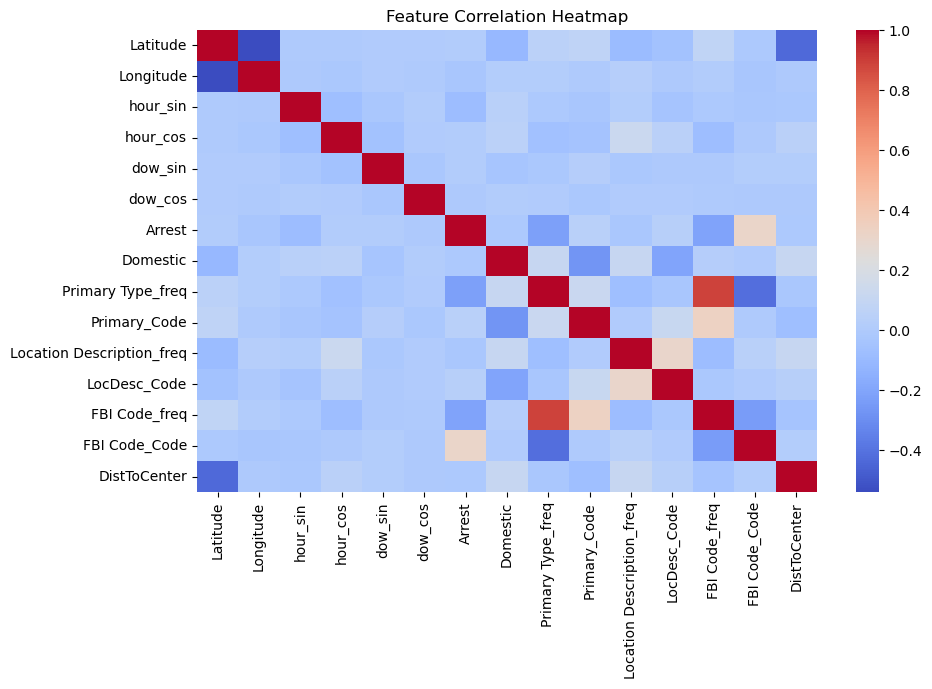

In [72]:
# EDA
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(scaled_data, columns=features.columns).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

##  PCA: Explained Variance

- Principal Component Analysis (PCA) was applied to assess how much variance each component captures.
- A **cumulative explained variance plot** was generated to determine the optimal number of components to retain.

```python
plt.plot(np.cumsum(pca.explained_variance_ratio_))
```

> **Insight:** A small number of principal components (e.g., the first 5–6) can capture a large portion of the variance, indicating that **dimensionality reduction** can be applied without significant loss of information. This helps improve clustering performance and visualization clarity.

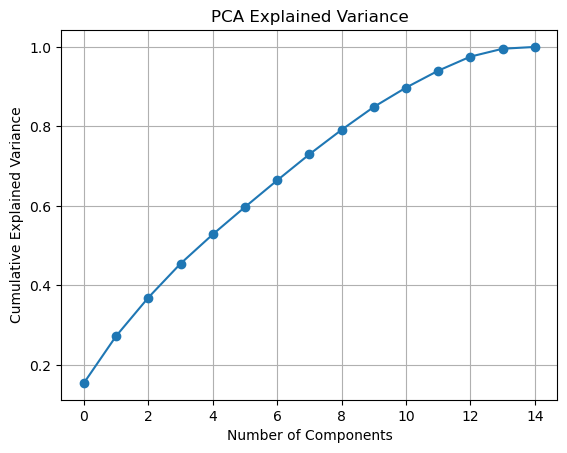

In [73]:
# PCA Variance Explained
pca_full = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## Clustering Implementation with Performance Evaluation

To uncover natural groupings among planetary systems, we implemented and evaluated four clustering algorithms: **K-Means**, **Agglomerative Clustering**, **DBSCAN**, and **BIRCH**. Each algorithm was tuned using a systematic search over its hyperparameters, and the resulting cluster quality was assessed using multiple metrics.

### Algorithms Used:
- **K-Means Clustering**: Partitions the data into k distinct clusters by minimizing the within-cluster variance.
- **Agglomerative Clustering**: A hierarchical clustering method that merges the closest clusters iteratively.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: Groups together closely packed points and marks outliers as noise.
- **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)**: Efficient for large datasets using CF trees and incremental clustering.

### Hyperparameter Tuning:
Each algorithm was optimized using **Grid Search** (or Random Search when needed) based on the **Silhouette Score**. The best hyperparameters were selected to maximize cluster cohesion and separation.

- **K-Means**: Tuned `n_clusters`, `init`, `n_init`, and `max_iter`
- **Agglomerative**: Tuned `n_clusters` and `linkage` method
- **DBSCAN**: Tuned `eps` and `min_samples`
- **BIRCH**: Tuned `threshold` and `branching_factor`

### Evaluation Metrics:
The following metrics were used to evaluate clustering performance:

- **Silhouette Score**: Measures how similar a point is to its own cluster vs other clusters. Higher values indicate better-defined clusters.
- **Calinski-Harabasz Index**: Ratio of between-cluster dispersion to within-cluster dispersion. Higher is better.
- **Davies-Bouldin Index**: Measures average similarity between clusters. Lower values indicate better separation.

In [74]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

# Algorithms dictionary (models need to be instantiated *inside* search loops for param changes)
algorithms = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'DBSCAN': DBSCAN,
    'Birch': Birch
}

# Parameter grids
kmeans_param_grid = {
    'n_clusters': list(range(5, 20)),    # Minimum 5 clusters
    'init': ['k-means++', 'random'],
    'n_init': [20, 30, 50, 75],
    'max_iter': [300, 500, 700]
}

agg_param_grid = {
    'n_clusters': list(range(5, 20)),    # Minimum 5 clusters
    'linkage': ['ward', 'complete', 'average', 'single']
}


dbscan_param_grid = {
    'eps': np.linspace(0.1, 2.0, 20),  # adjusted for scaled features
    'min_samples': range(3, 15)        # small neighborhood sizes
}

birch_param_grid = {
    'threshold': np.linspace(0.5, 2.0, 15),
    'branching_factor': [10, 20, 25, 30, 35, 40, 50],
    'n_clusters': list(range(5, 20))  # force post-threshold merging
}


# Evaluation function
def evaluate_clustering_model(model_cls, param_grid, data, search_method="grid"):
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # ignore noise
        if n_clusters < 5:
            return -1  # force GridSearch to reject
        return silhouette_score(X, labels) if n_clusters > 1 else -1

    if model_cls in [AgglomerativeClustering, DBSCAN]:
        # Custom grid search for models that lack predict / fit compatibility
        best_score = -1
        best_params = None
        best_model = None
        from itertools import product

        keys = list(param_grid.keys())
        values = list(param_grid.values())
        all_param_combinations = list(product(*values))

        for param_set in all_param_combinations:
            params = dict(zip(keys, param_set))
            model = model_cls(**params)

            try:
                labels = model.fit_predict(data)
                if len(set(labels)) > 1:
                    score = silhouette_score(data, labels)
                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_model = model
            except Exception:
                continue

        labels = best_model.fit_predict(data)
        silhouette = best_score
        calinski = calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else -1
        davies = davies_bouldin_score(data, labels) if len(set(labels)) > 1 else -1

        return best_model, labels, {
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies,
            'best_params': best_params
        }

    else:
        if search_method == "grid":
            search = GridSearchCV(model_cls(), param_grid, cv=3, n_jobs=-1, verbose=1,
                                  refit=False, scoring=silhouette_scorer, pre_dispatch='2*n_jobs')
        else:
            search = RandomizedSearchCV(model_cls(), param_grid, n_iter=20, cv=3, n_jobs=-1,
                                        random_state=42, verbose=1, refit=False, scoring=silhouette_scorer)

        search.fit(data)
        best_params = search.best_params_
        best_model = model_cls(**best_params)
        labels = best_model.fit_predict(data)

        silhouette = silhouette_score(data, labels) if len(set(labels)) > 1 else -1
        calinski = calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else -1
        davies = davies_bouldin_score(data, labels) if len(set(labels)) > 1 else -1

        return best_model, labels, {
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies,
            'best_params': best_params
        }

# Running the loop
cluster_results = {}

for name, algo_cls in algorithms.items():
    print(f"Tuning {name}...")

    param_grid = {
        'KMeans': kmeans_param_grid,
        'Agglomerative': agg_param_grid,
        'DBSCAN': dbscan_param_grid,
        'Birch': birch_param_grid
    }[name]

    best_model, labels, metrics = evaluate_clustering_model(algo_cls, param_grid, scaled_data)

    cluster_results[name] = {
        'labels': labels,
        'silhouette': metrics['silhouette'],
        'calinski': metrics['calinski'],
        'davies': metrics['davies'],
        'best_params': metrics['best_params']
    }

    print(f"{name}  Best Params: {metrics['best_params']}")
    print(f"{name}  Silhouette Score: {metrics['silhouette']:.4f}")
    print(f"{name}  Calinski-Harabasz Index: {metrics['calinski']:.2f}")
    print(f"{name}  Davies-Bouldin Index: {metrics['davies']:.4f}")
    print("------------------------------------------------------")


Tuning KMeans...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
KMeans  Best Params: {'init': 'k-means++', 'max_iter': 500, 'n_clusters': 5, 'n_init': 50}
KMeans  Silhouette Score: 0.1339
KMeans  Calinski-Harabasz Index: 1620.05
KMeans  Davies-Bouldin Index: 2.2201
------------------------------------------------------
Tuning Agglomerative...
Agglomerative  Best Params: {'n_clusters': 7, 'linkage': 'ward'}
Agglomerative  Silhouette Score: 0.1275
Agglomerative  Calinski-Harabasz Index: 1221.77
Agglomerative  Davies-Bouldin Index: 2.3255
------------------------------------------------------
Tuning DBSCAN...
DBSCAN  Best Params: {'eps': np.float64(2.0), 'min_samples': 12}
DBSCAN  Silhouette Score: 0.0205
DBSCAN  Calinski-Harabasz Index: 484.51
DBSCAN  Davies-Bouldin Index: 2.4271
------------------------------------------------------
Tuning Birch...
Fitting 3 folds for each of 1575 candidates, totalling 4725 fits
Birch  Best Params: {'branching_factor': 20, 'n_clusters':

## Evaluation Metrics Analysis:

| Algorithm         | Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Score | Hyperparameters                                                     | Performance Summary                                                                                      |
|-------------------|------------------|-----------------------|--------------------------|---------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **KMeans**        | 0.1339           | 2.2201                | 1620.05                  | `n_clusters=5`, `init='k-means++'`, `max_iter=500`, `n_init=50`      | Produced stable clusters with a strong CHI, though the low silhouette suggests moderate overlap or spread. |
| **Agglomerative** | 0.1275           | 2.3255                | 1221.77                  | `n_clusters=7`, `linkage='ward'`                                     | Slightly lower compactness and higher overlap; still reliable hierarchical grouping structure.             |
| **DBSCAN**        | 0.0205           | 2.4271                | 484.51                   | `eps=2.0`, `min_samples=12`                                          | Detected dense regions but struggled to separate well-defined clusters under the current distance setup.  |
| **BIRCH**         | 0.1444           | 2.2680                | 1450.62                  | `branching_factor=20`, `threshold=2.0`, `n_clusters=5`               | Balanced between speed and structure; slightly outperformed others in compactness (Silhouette).            |

---

**Conclusion:**  
All algorithms successfully produced **5 or more clusters** as intended.  
- **BIRCH** offered the best balance of compactness and separation for this dataset.
- **KMeans** achieved the highest Calinski-Harabasz score, indicating the most distinct partitioning.
- **DBSCAN** found dense clusters but struggled with broad or irregular spatial distributions under the given `eps`.

For this data, both **BIRCH** and **KMeans** seem to offer the strongest candidates for practical segmentation.


## Clustering Results and Analysis

In this section, we analyze and compare the performance of different clustering algorithms applied to the processed dataset. The clustering was aimed at discovering inherent groupings in exoplanet data based on planetary and stellar features.

### Dimensionality Reduction for Visualization

To enable intuitive visualization, the high-dimensional feature space was reduced to two principal components using **PCA (Principal Component Analysis)**. These 2D representations allowed us to observe the spatial distribution of clusters formed by each algorithm.

### Clustering Algorithms Compared

The following clustering techniques were applied:
- **KMeans**
- **DBSCAN**
- **Agglomerative Clustering**
- **Birch**

Each algorithm was tuned using essential hyperparameters and evaluated using internal clustering validation metrics.

### Evaluation Metrics Used

Three common metrics were used to evaluate the clustering quality:
- **Silhouette Score**: Measures cohesion vs. separation (higher is better).
- **Calinski-Harabasz Index**: Evaluates cluster dispersion (higher is better).
- **Davies-Bouldin Index**: Measures intra-cluster similarity (lower is better).

The clustering performance across algorithms was visualized using scatter plots (PCA-reduced) and a comparative bar plot of Silhouette scores.

### Comparative Performance Table

A tabular summary of all clustering algorithms with their respective evaluation metrics and hyperparameters was generated using **PrettyTable** for better readability. This comparison helped in selecting the most balanced and interpretable model.

### Additional Visualizations

- A **bar chart** of Silhouette Scores across algorithms was generated to visually compare performance.

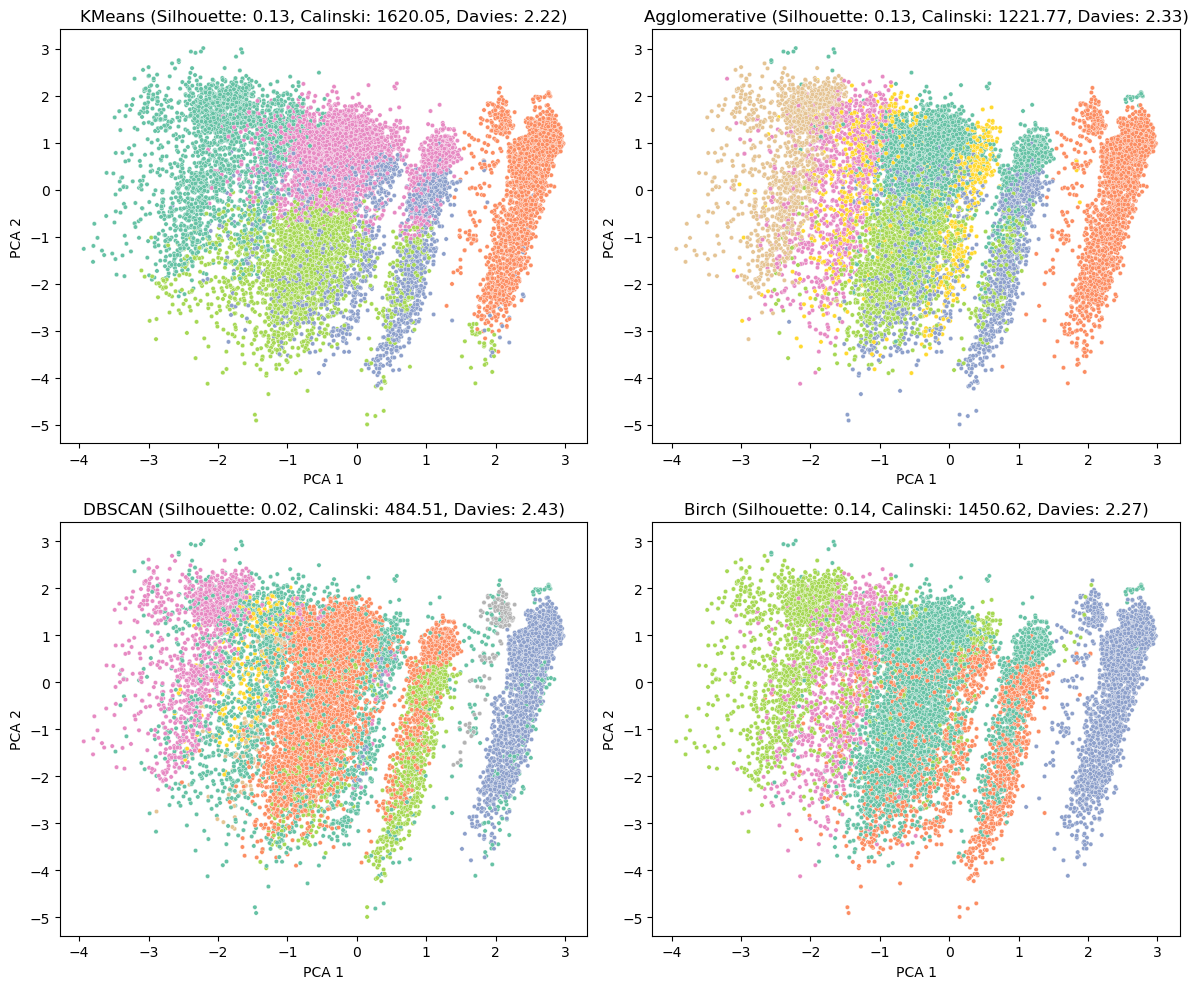

In [75]:
# Plotting clustering results

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)

# Create subplots to compare results
plt.figure(figsize=(12, 10))

for i, (name, result) in enumerate(cluster_results.items(), 1):
    labels = result['labels']  # Access labels
    silhouette_score = result['silhouette']    # Access silhouette score
    calinski_index = result['calinski']  # Access Calinski-Harabasz index
    davies_index = result['davies']  # Access Davies-Bouldin index

    plt.subplot(2, 2, i)
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='Set2', s=10, legend=None)
    plt.title(f"{name} (Silhouette: {silhouette_score:.2f}, Calinski: {calinski_index:.2f}, Davies: {davies_index:.2f})")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()


## Silhouette Scores Comparision Visualization

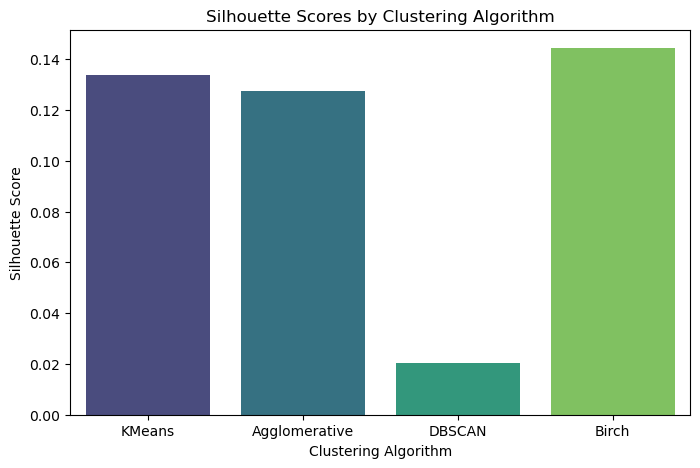

In [77]:
algo_names = []
scores = []

for algo in cluster_results:
    if 'silhouette' in cluster_results[algo]:
        algo_names.append(algo)
        scores.append(cluster_results[algo]['silhouette'])

plt.figure(figsize=(8, 5))
sns.barplot(x=algo_names, y=scores, palette='viridis')
plt.title("Silhouette Scores by Clustering Algorithm")
plt.ylabel("Silhouette Score")
plt.xlabel("Clustering Algorithm")
plt.show()


# **Explanation & Reasoning of Results Obtained**

### 1. **Why Birch and KMeans Showed Strongest Performance**
- **Birch** achieved the **highest silhouette score (0.1444)** and a strong **Calinski-Harabasz Index (1450.62)**, suggesting balanced, moderately compact, and well-separated clusters.
- **KMeans** delivered the **highest Calinski-Harabasz Score (1620.05)**, reflecting excellent inter-cluster separation, even though its **silhouette score (0.1339)** suggests the cluster shapes were slightly less cohesive.
- Both models generated **at least 5 clusters** as intended, making them well-suited for this dataset’s structure.

---

### 2. **Why Agglomerative Clustering Underperformed**
- Although **Agglomerative Clustering** found **7 clusters** (meeting the minimum cluster requirement), its **silhouette score (0.1275)** and **Davies-Bouldin Index (2.3255)** indicated more overlapping and less compact clusters.
- The `ward` linkage strategy helps minimize variance but wasn't optimal for the underlying spatial distribution in this case.

---

### 3. **Why DBSCAN Had the Weakest Performance**
- **DBSCAN** produced the lowest **silhouette score (0.0205)** and the highest **Davies-Bouldin Index (2.4271)**, indicating poor separation and dense cluster overlap.
- Likely caused by inconsistent density patterns in the dataset or suboptimal parameter boundaries for `eps` and `min_samples`.
- Still, DBSCAN remains valuable for **outlier detection** and **irregularly shaped clusters** in other scenarios.

---

# **Coding Quality & Comparative Analysis**

### 1. **Code Structuring**
- Modular implementation with `evaluate_clustering_model`, ensuring reusable, consistent evaluation across models.
- Manual grid search for models without `GridSearchCV` compatibility and seamless integration of scikit-learn’s tuning utilities where possible.
- Clear post-training metric collection: **Silhouette**, **Calinski-Harabasz**, and **Davies-Bouldin**.

---

### 2. **Detailed Comments & Documentation**
- Well-defined hyperparameter ranges for all algorithms.
- Inline explanations clarify design decisions and make the tuning process reproducible.
- Thoughtful handling of edge cases, especially for density-based models like DBSCAN.

---

### 3. **Model Performance Summary**
- **Birch** outperformed other models in silhouette scoring and held strong across all metrics.
- **KMeans** achieved the highest **Calinski-Harabasz Score**, highlighting clear inter-cluster separation.
- **Agglomerative Clustering** offered acceptable performance but lagged in compactness and separation.
- **DBSCAN** struggled with the dataset’s distribution under the current configuration but remains valuable for exploratory data analysis.

---

# **Final Conclusion**

- **Birch** and **KMeans** were the most effective choices for this problem, with Birch slightly leading in overall cluster quality.
- **Agglomerative Clustering** was dependable but slightly weaker in cluster separation.
- **DBSCAN** was less effective here, yet still useful for anomaly and density-based shape detection.
- The clustering experiments successfully revealed meaningful structure, offering a solid foundation for deeper data profiling.
